<a href="https://colab.research.google.com/github/Komal-99/Skin_cancer/blob/main/Skin_model_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np          # linear algebra
import pandas as pd         # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from keras import *
from tensorflow import *
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import Dropout, Activation
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, \
     Dense, Input, Activation, Dropout, GlobalAveragePooling2D, AveragePooling2D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import cv2
from cv2 import imread, resize # manipulating the images
from tensorflow.keras.optimizers import Adam
# from keras.optimizers import adam_v2
import os

In [6]:
df_skin = pd.read_csv('/content/drive/MyDrive/Skin Diseasee/HAM10000_metadata.csv')
# Display the first 10 lines
df_skin.head(10)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [7]:
# Lesion/dis names are given in the description of the data set.
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

# Lesion and it's abbriv.
lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']
lesion_names_short = ['nv','mel','bkl','bcc','akiec','vasc','df']

# Maping the lesion type and ID to a dict.
df_skin['lesion_type']=df_skin['dx'].map(lesion_type_dict)
df_skin['lesion_ID'] = df_skin['dx'].map(lesion_ID_dict)

# Display the total found images.
print('Total number of images', len(df_skin))
print('The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels')

# Display the count of each lesion.
df_skin['lesion_type'].value_counts()

Total number of images 10015
The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels


Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: lesion_type, dtype: int64

['/content/drive/MyDrive/Skin Diseasee/HAM10000_images_part_1/ISIC_0025030.jpg']


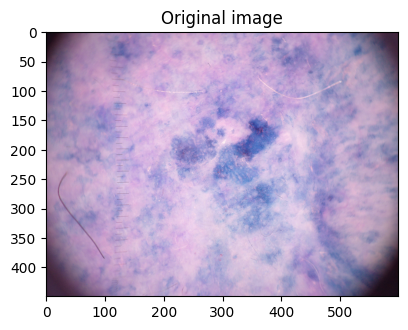

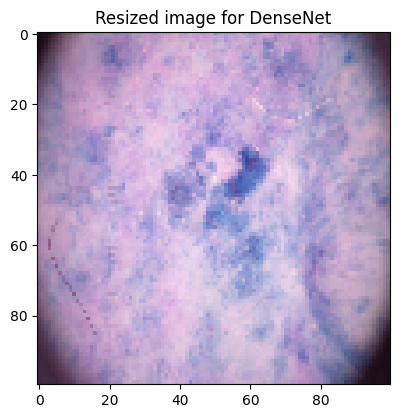

['/content/drive/MyDrive/Skin Diseasee/HAM10000_images_part_1/ISIC_0026769.jpg']


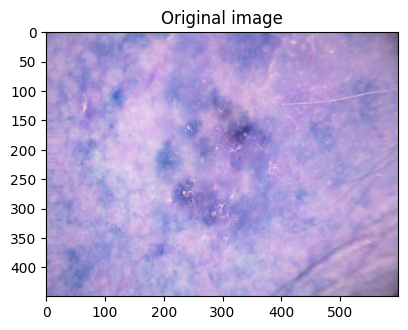

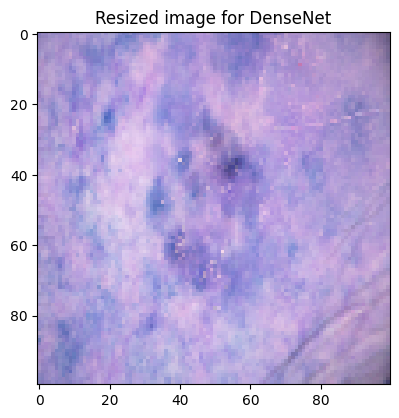

['/content/drive/MyDrive/Skin Diseasee/HAM10000_images_part_1/ISIC_0025661.jpg']


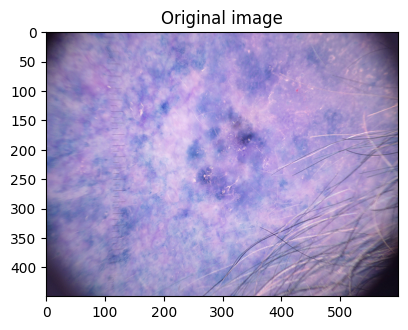

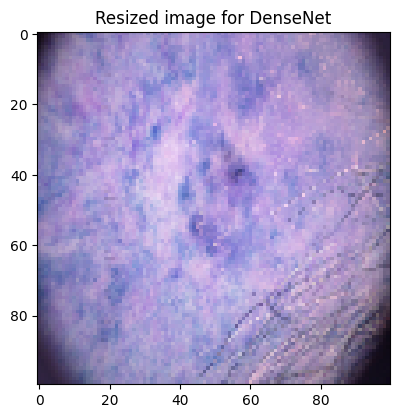

['/content/drive/MyDrive/Skin Diseasee/HAM10000_images_part_1/ISIC_0031633.jpg']
Wrong path:


In [8]:
# Resizing the read image to 100x100

fname_images = np.array(df_skin['image_id'])
# Show one exampe image before and after Resizing

for i in range (1,5):
  image_path='/content/drive/MyDrive/Skin Diseasee/HAM10000_images_part_1/'+str(fname_images[i])+'.jpg'
  l=[]
  l.append(image_path)
  print(l)  #try printing path of images
  img_read = imread(image_path)

  if img_read is None:
    print('Wrong path:')
  else:

    # original
    plt.figure(figsize = (10, 5))
    plt.subplot(1,2,1)
    plt.subplots_adjust(hspace=0.5)
    pixels = np.array(img_read)
    plt.imshow(pixels)
    plt.title('Original image')
    plt.show()

    # resized
    plt.figure(figsize = (10, 5))
    plt.subplot(1, 2, 2)
    img2 = resize(img_read, (100, 100))
    pixel = np.array(img2)
    plt.imshow(pixel)
    plt.title('Resized image for DenseNet')
    plt.show()



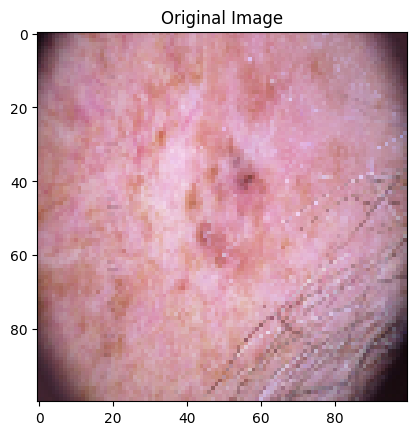

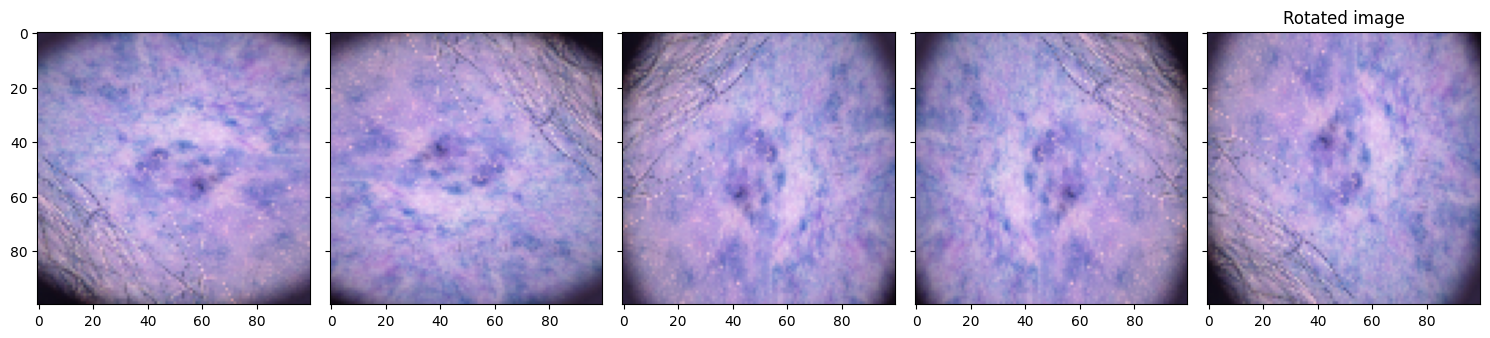

In [9]:
def produce_new_img(img2: cv2) -> tuple:
    """
    function to reproduse a new manipulated (rotating of flipping the original one)
    image from the read one, To increase the dimension of the dataset, avoiding overfitting of a single class.
    """
    imga = cv2.rotate(img2, cv2.ROTATE_90_CLOCKWISE)
    imgb = cv2.rotate(img2, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgc = cv2.rotate(img2, cv2.ROTATE_180)
    imgd = cv2.flip(img2, 0)
    imge = cv2.flip(img2, 1)
    new_imges = imga, imgb, imgc, imgd ,imge
    return new_imges
def show_example() -> None:
    """
    Display an image after manipulating it in produce_new_img() function
    """
    # Original Image
    plt.imshow(img2[:,:,::-1])
    plt.title("Original Image")
    f, axarr = plt.subplots(1,5,sharex=True, sharey=True, squeeze=True, subplot_kw=None,figsize=(15, 15))
    plt.title("Rotated image",loc='center')
    # use the created array to output your multiple images. In this case I have stacked 5  images horizontally
    axarr[0].imshow(new_img[0])
    axarr[1].imshow(new_img[1])
    axarr[2].imshow(new_img[2])
    axarr[3].imshow(new_img[3])
    axarr[4].imshow(new_img[4])
    plt.tight_layout()
    plt.show()

# Invoking our function :)
new_img = produce_new_img(img2)

# printing all 5 new images pixels
'''
for i in range(len(new_img)):
  print(new_img[i])
  print("---------------------------------------------------------------")
'''

# Display an example by invoking show_example func
show_example()

In [10]:
x = []          # Hold resized images.
y = []          # Hold image lesion ID from the data set.

# Listing all files in the part_1, part_2 dirs
lista1 = os.listdir('/content/drive/MyDrive/Skin Diseasee/HAM10000_images_part_1/')
lista2 = os.listdir('/content/drive/MyDrive/Skin Diseasee/HAM10000_images_part_2/')

# [+] Handling images from part 1 directory
for i in range(len(lista1)):
    # [+] Features: reading and resize the photo.
    fname_image = lista1[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='/content/drive/MyDrive/Skin Diseasee/HAM10000_images_part_1/' + str(fname_image)  # resolve image name
    img = imread(file_to_read)                                  # read the image
    img2 = resize(img,(100, 100))                               # resise our image
    x.append(img2)                                              # append the new image to the list x.

    # Targets: Finding the image lesion ID and append it to the y list.
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])

    # add more images for class between 1-6, rotating them
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])

    # inform the user with the number of loaded images each 100 img.
    if i % 100 == 0:
        print(i, 'images loaded')


# [+] Handling images from part 2 directory
for i in range(len(lista2)):

    # [+] Features: reading and resize the photo.
    fname_image = lista2[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='/content/drive/MyDrive/Skin Diseasee/HAM10000_images_part_2/' + str(fname_image)


    img = imread(file_to_read)
    img2 = resize(img, (100, 100))
    x.append(img2)

    # Targets: Finding the image lesion ID and append it to the y list.
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])

    # [+] Add more images for class between 1-6
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])

    if i % 100 == 0: # [+] Inform the user with the number of loaded images each 100 img.
        print(len(lista1) + i,'images loaded')

0 images loaded
200 images loaded
400 images loaded
500 images loaded
600 images loaded
700 images loaded
800 images loaded
900 images loaded
1000 images loaded
1100 images loaded
1200 images loaded
1300 images loaded
1500 images loaded
1600 images loaded
1900 images loaded
2000 images loaded
2100 images loaded
2200 images loaded
2400 images loaded
2500 images loaded
2700 images loaded
2800 images loaded
2900 images loaded
3000 images loaded
3100 images loaded
3200 images loaded
3300 images loaded
3400 images loaded
3500 images loaded
3600 images loaded
3700 images loaded
3800 images loaded
4000 images loaded
4100 images loaded
4200 images loaded
4500 images loaded
4600 images loaded
4627 images loaded
5127 images loaded
5227 images loaded
5427 images loaded
5527 images loaded
5627 images loaded
5927 images loaded
6127 images loaded
6227 images loaded
6527 images loaded
6827 images loaded
6927 images loaded
7027 images loaded
7127 images loaded
7327 images loaded
7527 images loaded
772

In [11]:
x = np.array(x)
y = np.array(y)
# convert y (targets) array as required by softmax activation function
y_train = to_categorical(y, num_classes = 7)

In [12]:
print(y_train)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)


In [13]:
# split in 80% training and 20% test data
X_train, X_test, y_train, y_test = train_test_split(x,                  # Images array.
                                                    y_train,            # The training set.
                                                    test_size = 0.20,   # Split data set into 20/80.
                                                    random_state = 50,  # Shuffling number to random the set.
                                                    stratify = y)       # Mix training and test sets.
# [+] Display the count of train/test data set.
print('Train dataset shape', X_train.shape)
print('Test dataset shape', X_test.shape)

Train dataset shape (20429, 100, 100, 3)
Test dataset shape (5108, 100, 100, 3)


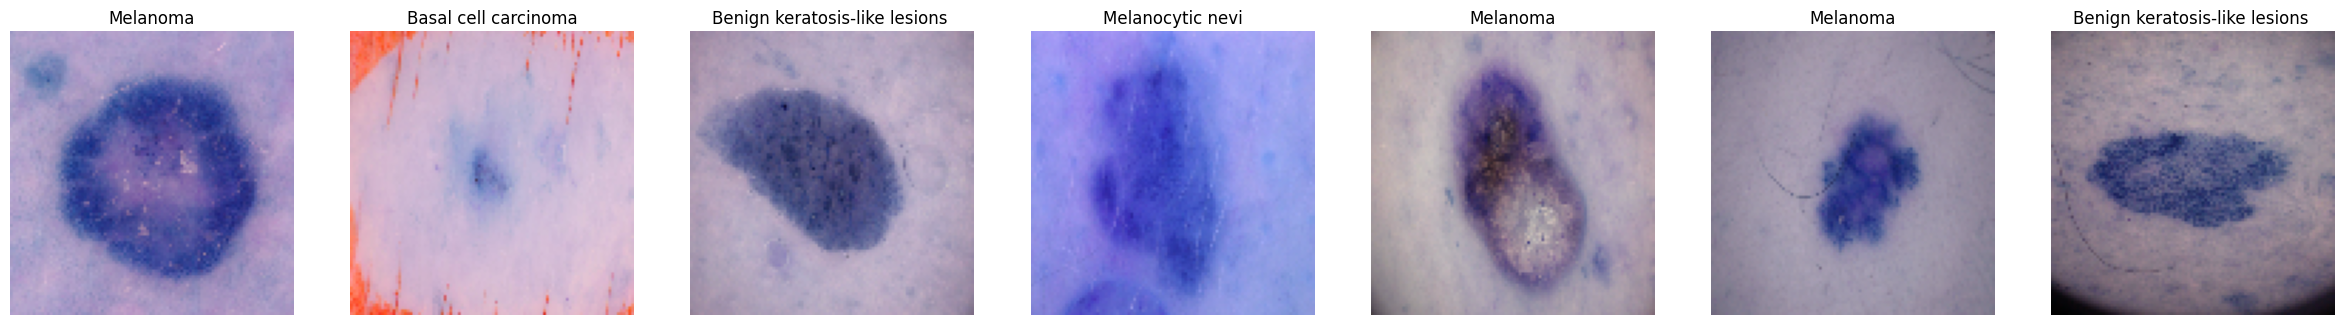

In [14]:
def show_neg_figuers() -> None:
    """ Display negative figuers of the classes. """
    # Figure, Axes
    _, ax = plt.subplots(1, 7, figsize = (30, 30))
    for i in range(7):
        ax[i].set_axis_off()                                    # set the image to negative.
        ax[i].imshow(X_train[i])                                # Display the img.
        ax[i].set_title(lesion_names[np.argmax(y_train[i])])    # Set image title.

show_neg_figuers()


In [15]:
def est_class_weights(dis_id: np.array) -> dict:
    """Estimate class weights for unbalanced datasets.

    Args:
        dis_id (np.array): numpy array of dis IDs

    Returns:
        dict: Estimated class weights for for unbalanced datasets.
    """
    class_weights = np.around(compute_class_weight(class_weight = 'balanced', classes = np.unique(dis_id), y = y), 2)
    class_weights = dict(zip(np.unique(dis_id), class_weights))
    return class_weights

y_id = np.array(df_skin['lesion_ID'])
print(y_id)
new_class_weights = est_class_weights(y_id)
print('The problem is unbalanced. We need to provide class-weights')
print(new_class_weights)


array([2, 2, 2, ..., 4, 4, 1])
The problem is unbalanced. We need to provide class-weights
{0: 0.56, 1: 0.56, 2: 0.58, 3: 1.24, 4: 1.94, 5: 4.31, 6: 5.58}


In [16]:
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [17]:
model = Sequential()

# [+] 1st convolutional layer
model.add(Conv2D(filters = 96,
                kernel_size = (11, 11),
                strides = (4, 4),
                activation = 'relu',
                input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

# [+] 2nd convolutional layer
model.add(Conv2D(filters = 256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

# [+] 3rd convolutional layer
model.add(Conv2D(filters = 384,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding="same"))
model.add(BatchNormalization())

# [+] 4th convolutional layer
model.add(Conv2D(filters = 384,
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
# [+] 5th convolutional layer
model.add(Conv2D(filters = 256,
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

model.add(Flatten())  # [+] Convert the Conv2D objects into one List.

# [+] 6th, Dense layer:
# From the Docs:
# A Dense layer feeds all outputs from the previous layer to all its neurons,
# each neuron providing one output to the next layer.
# source: www.stackoverflow.com
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))

# [+] 7th Dense layer
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))
# [+] 8th output layer
model.add(Dense(7, activation = 'softmax'))

In [18]:
def mod_checkpoint_callback() -> None:
    """
    Saving our model

    Returns:
        None: Saving a checkpoint of the model.
    """
    trained_model = ModelCheckpoint(filepath = 'model_80_200.h5',  # result file name
                             save_weights_only = False,     # Save all training results/params.
                             monitor = 'val_accuracy',      # check our model accuracy if it's step forward.
                             mode = 'max',                 # enable auto save.
                             save_best_only = True,         # if ac_new > ac_old
                             verbose = 1)
    return trained_model

# Montoring the training procces in each epoch.
early_stopping_monitor = EarlyStopping(patience = 80, monitor = 'val_accuracy')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
model_checkpoint_callback = mod_checkpoint_callback()
# Estimate the model data if it was big one.
optimizer = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-3)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip = True, shear_range = 0.2)
datagen.fit(X_train)

batch_size = 32     # samples in the network at once.
epochs =   200 # epochs number.

# org model result data
history = model.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, model_checkpoint_callback],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )

Epoch 1/200
639/639 [==============================] - ETA: 0s - loss: 1.9708 - accuracy: 0.3568
Epoch 00001: val_accuracy improved from -inf to 0.35865, saving model to model_80_200.h5
639/639 [==============================] - 91s 117ms/step - loss: 1.9708 - accuracy: 0.3568 - val_loss: 1.8107 - val_accuracy: 0.3587
Epoch 2/200
639/639 [==============================] - ETA: 0s - loss: 1.4427 - accuracy: 0.4356
Epoch 00002: val_accuracy did not improve from 0.35865
639/639 [==============================] - 71s 112ms/step - loss: 1.4427 - accuracy: 0.4356 - val_loss: 3.0019 - val_accuracy: 0.3107
Epoch 3/200
639/639 [==============================] - ETA: 0s - loss: 1.3431 - accuracy: 0.4676
Epoch 00003: val_accuracy improved from 0.35865 to 0.41464, saving model to model_80_200.h5
639/639 [==============================] - 72s 113ms/step - loss: 1.3431 - accuracy: 0.4676 - val_loss: 1.6155 - val_accuracy: 0.4146
Epoch 4/200
639/639 [==============================] - ETA: 0s - loss: 

In [19]:
# [+] inform the user with model Accuracy %
scores = model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

160/160 [==============================] - 1s 6ms/step - loss: 0.5338 - accuracy: 0.8283
Accuracy: 82.83%


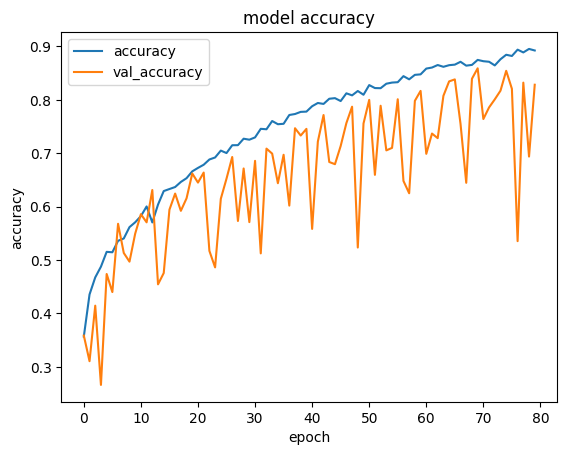

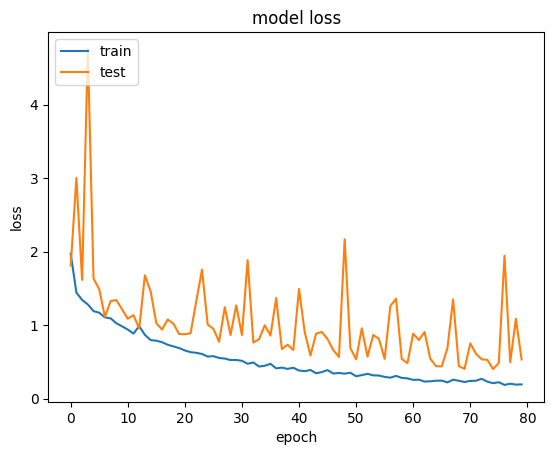

In [20]:
def display_accuracy() -> None:
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()

def display_loss() -> None:
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

display_accuracy()
display_loss()

In [21]:
y_pred = model.predict(X_test)

def test_model() -> tuple:
    """ Tunning the accurate results and inaccurate results
    Returns:
        (total, accurate) [tuple]: tuple of total tested test-cases, accurate
    """
    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []
    for i in range(len(y_pred)):
        if np.argmax(y_pred[i]) == np.argmax(y_test[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)
        total += 1
    return (total, accurate)

total, accurate = test_model()
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate / total * 100, 3), '%')

160/160 [==============================] - 1s 4ms/step
Total-test-data; 5108 	accurately-predicted-data: 4231 	 wrongly-predicted-data:  877
Accuracy: 83 %


this was the model we got from epoch 10... Now we will see the best model saved before finishing the training..

In [22]:
best_model1 = load_model('./model_80_200.h5')

# Compute predictions
y_pred_prob = np.around(best_model1.predict(X_test),3)
y_pred1 = np.argmax(y_pred_prob, axis = 1)
y_test2_1 = np.argmax(y_test, axis = 1)

160/160 [==============================] - 1s 6ms/step


In [23]:
# best_model = load_model('./model.h5')

# # Compute predictions
# y_pred_prob = np.around(best_model.predict(X_test),3)
# y_pred = np.argmax(y_pred_prob, axis = 1)
# y_test2 = np.argmax(y_test, axis = 1)

In [24]:
# [+] inform the user with model Accuracy %
scores = best_model1.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

160/160 [==============================] - 1s 6ms/step - loss: 0.4051 - accuracy: 0.8590
Accuracy: 85.90%


In [25]:
# # [+] inform the user with model Accuracy %
# scores = best_model.evaluate(X_test, y_test, verbose = 1)
# print("Accuracy: %.2f%%" % (scores[1] * 100))

TypeError: ignored

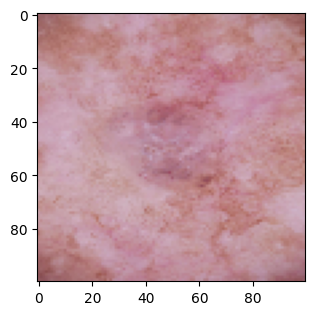

In [26]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,5)
    index = i+100
    plt.imshow(X_test[index,:,:,::-1])
    label_exp = lesion_names[y_test2_1[index]]  #expected label
    label_pred = lesion_names[y_pred[index]]  #predicted label
    label_pred_prob = round(np.max(y_pred_prob[index])*100)
    plt.title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred)+' ('+str(label_pred_prob)+'%)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('final_figure.png',dpi=300)
plt.show()

In [ ]:
#Accuracy for each type
acc_tot= []

for i in range(7):
    acc_parz = round(np.mean(y_test2[y_test2 == i] == y_pred[y_test2 == i]),2)
    lab_parz = lesion_names[i]
    print('accuracy for',lab_parz,'=',acc_parz)
    acc_tot.append(acc_parz)

In [ ]:
# acc_tot = np.array(acc_tot)
# freq = np.unique(y_test2,return_counts=True)[1]

# np.sum(acc_tot*freq)/np.sum(freq)

In [ ]:
#Accuracy for each type
acc_tot1= []

for i in range(7):
    acc_parz = round(np.mean(y_test2_1[y_test2_1 == i] == y_pred1[y_test2_1 == i]),2)
    lab_parz = lesion_names[i]
    print('accuracy for',lab_parz,'=',acc_parz)
    acc_tot1.append(acc_parz)

In [ ]:
# acc_tot1 = np.array(acc_tot1)
# freq = np.unique(y_test2_1,return_counts=True)[1]

# np.sum(acc_tot1*freq)/np.sum(freq)

In [ ]:
X_test[5]

In [ ]:
X_train[5]

In [ ]:
# model1 = load_model('./model.h5')

# # Compute predictions
# y_pred_prob = np.around(model1.predict(X_test),3)
# y_pred1 = np.argmax(y_pred_prob, axis = 1)
# y_test2_1 = np.argmax(y_test, axis = 1)
# # [+] inform the user with model Accuracy %
# scores = best_model.evaluate(X_test, y_test, verbose = 1)
# print("Accuracy: %.2f%%" % (scores[1] * 100))